In [1]:
import glob

import cartopy.crs as ccrs
import cftime
import cmocean as cmo
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import om4labs.om4common as om4
import pandas as pd
import scipy.signal as signal
import xarray as xr

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = "/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/"
out_path_data = "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/"

In [13]:
index = "SAM"

if index == "storms":
    ds = xr.open_dataset(
        "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_monthly_storms.nc",
        use_cftime=True,
    )

    storms_seasonal = ds.center_counts.resample(time="QS-DEC").sum()

    idx_jja = storms_seasonal.time.dt.month == 6
    idx_djf = storms_seasonal.time.dt.month == 12

    storms_djf = storms_seasonal[idx_djf][1:-1]
    storms_jja = storms_seasonal[idx_jja]

    lo_djf = storms_djf.sortby(storms_djf).time[:50]
    hi_djf = storms_djf.sortby(storms_djf).time[-50:]

    idx_hi_djf = storms_djf.time.isin(hi_djf)
    idx_lo_djf = storms_djf.time.isin(lo_djf)

    lo_jja = storms_jja.sortby(storms_jja).time[:50]
    hi_jja = storms_jja.sortby(storms_jja).time[-50:]

    idx_hi_jja = storms_jja.time.isin(hi_jja)
    idx_lo_jja = storms_jja.time.isin(lo_jja)

if index == "SAM":
    ds_djf = xr.open_dataset(
        "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_DJF_SAM.nc"
    )
    ds_jja = xr.open_dataset(
        "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/ESM4_cmip_JJA_SAM.nc"
    )

    lo_djf = ds_djf.pcs[1:-1, 0].sortby(ds_djf.pcs[1:-1, 0]).time[:50]
    hi_djf = ds_djf.pcs[1:-1, 0].sortby(ds_djf.pcs[1:-1, 0]).time[-50:]

    lo_jja = ds_jja.pcs[:, 0].sortby(ds_jja.pcs[:, 0]).time[:50]
    hi_jja = ds_jja.pcs[:, 0].sortby(ds_jja.pcs[:, 0]).time[-50:]

    idx_hi_djf = ds_djf.time.isin(hi_djf)
    idx_lo_djf = ds_djf.time.isin(lo_djf)

    idx_hi_jja = ds_jja.time.isin(hi_jja)
    idx_lo_jja = ds_jja.time.isin(lo_jja)

# Creating composites for atmosphere/ocean/sea ice conditions

## 1. Atmospheric conditions - SLP

In [43]:
var = "slp"
ds_v = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/*{var}.nc", use_cftime=True
)

da_v = ds_v[var]

midx_djf = da_v.time.dt.month.isin([1, 2, 12])
midx_jja = da_v.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    da_v.time.dt.year.isin(hi_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(hi_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    da_v.time.dt.year.isin(lo_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(lo_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))

midx_hi_jja = da_v.time.dt.year.isin(hi_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = da_v.time.dt.year.isin(lo_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)

mean_djf = da_v[midx_djf, :, :].mean(dim="time").compute()
std_djf = da_v[midx_djf, :, :].std(dim="time").compute()

mean_jja = da_v[midx_jja, :, :].mean(dim="time").compute()
std_jja = da_v[midx_jja, :, :].std(dim="time").compute()

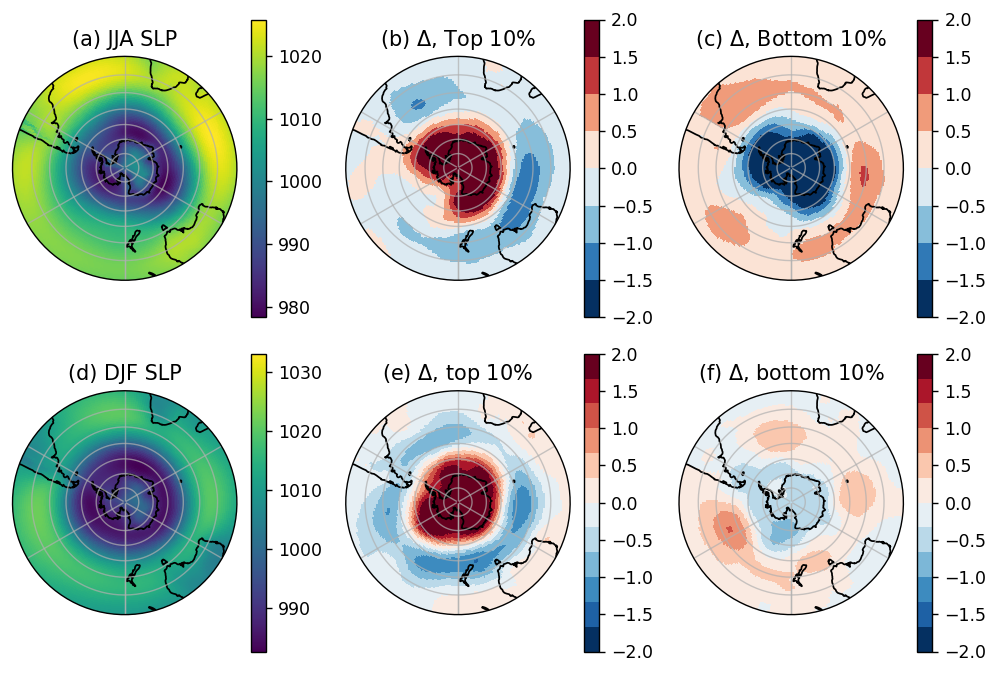

In [44]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

mean_jja.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) JJA SLP")

(da_v[midx_hi_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=2,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(da_v[midx_lo_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=2,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$, Bottom 10%")

mean_djf.plot(
    ax=axs[3],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[3].set_title("(d) DJF SLP")

(da_v[midx_hi_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=2,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) $\Delta$, top 10%")

(da_v[midx_lo_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-2,
    vmax=2,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(f) $\Delta$, bottom 10%")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

# axs[3].remove()
plt.tight_layout()

# plt.savefig(f"{out_path_fig}slp_djf_ESM4-500.png", format="png", dpi=100)

## 1a. Atmospheric conditions - Z500

In [19]:
var = "zg"
ds_v = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/*{var}.nc", use_cftime=True
)

# for variables that you have to subsample
da_v = ds_v[var].sel(plev39=500e2, method="nearest").compute()

midx_djf = da_v.time.dt.month.isin([1, 2, 12])
midx_jja = da_v.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    da_v.time.dt.year.isin(hi_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(hi_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    da_v.time.dt.year.isin(lo_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(lo_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))

midx_hi_jja = da_v.time.dt.year.isin(hi_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = da_v.time.dt.year.isin(lo_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)

mean_djf = da_v[midx_djf, :, :].mean(dim="time").compute()
std_djf = da_v[midx_djf, :, :].std(dim="time").compute()

mean_jja = da_v[midx_jja, :, :].mean(dim="time").compute()
std_jja = da_v[midx_jja, :, :].std(dim="time").compute()

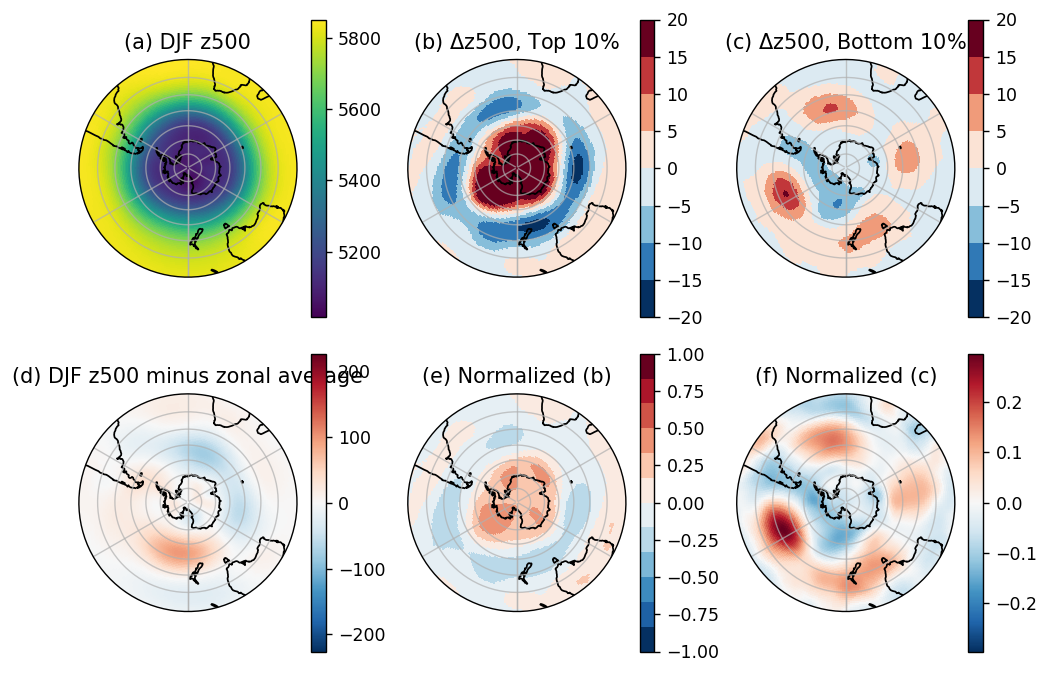

In [20]:
## Summer month composites

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


mean_djf.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) DJF z500")

## now including variations from zonal means

(mean_djf - mean_djf.mean(dim="lon")).plot(
    ax=axs[3],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=1020, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[3].set_title("(d) DJF z500 minus zonal average")


(da_v[midx_hi_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-20,
    vmax=20,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$z500, Top 10%")

(da_v[midx_lo_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-20,
    vmax=20,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$z500, Bottom 10%")


((da_v[midx_hi_djf, :, :].mean(dim="time") - mean_djf) / std_djf).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) Normalized (b)")

((da_v[midx_lo_djf, :, :].mean(dim="time") - mean_djf) / std_djf).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    #                                                   vmin=-1, vmax=1, extend='neither',
    #                                                   cmap=plt.get_cmap('RdBu_r', 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(f) Normalized (c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

# axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}z500_djf_ESM4-500.png", format="png", dpi=100)

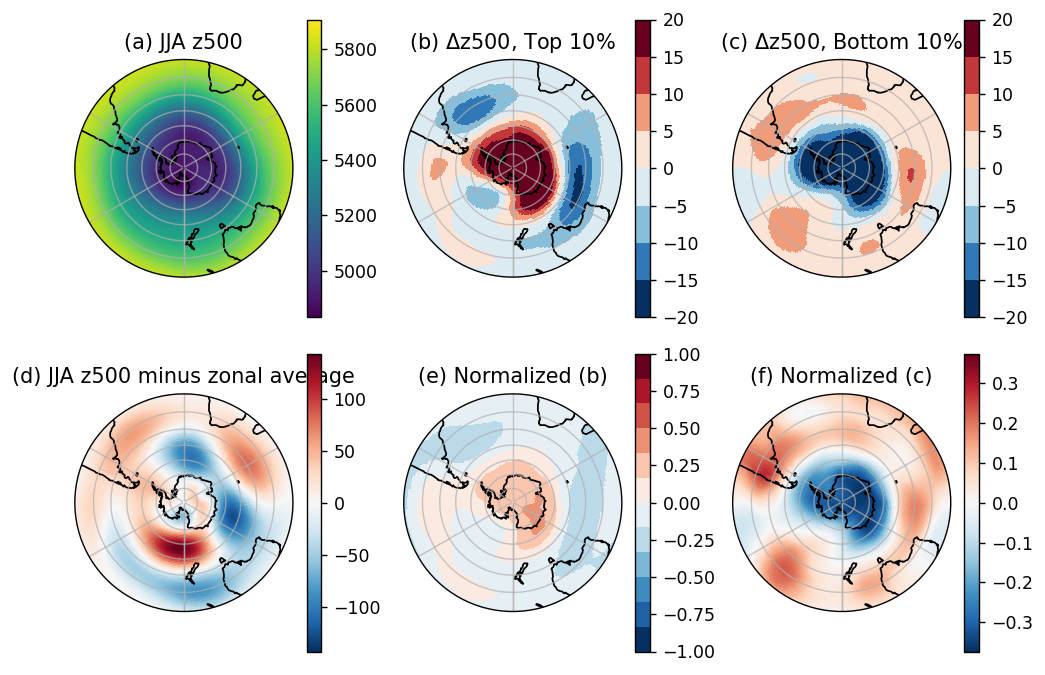

In [21]:
## Winter month composites

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


mean_jja.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) JJA z500")

## now including variations from zonal means

(mean_jja - mean_jja.mean(dim="lon")).plot(
    ax=axs[3],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=1020, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[3].set_title("(d) JJA z500 minus zonal average")


(da_v[midx_hi_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-20,
    vmax=20,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$z500, Top 10%")

(da_v[midx_lo_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-20,
    vmax=20,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 8),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$z500, Bottom 10%")


((da_v[midx_hi_jja, :, :].mean(dim="time") - mean_jja) / std_jja).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) Normalized (b)")

((da_v[midx_lo_jja, :, :].mean(dim="time") - mean_jja) / std_jja).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    #                                                   vmin=-1, vmax=1, extend='neither',
    #                                                   cmap=plt.get_cmap('RdBu_r', 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(f) Normalized (c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -20], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

# axs[3].remove()
plt.tight_layout()

plt.savefig(f"{out_path_fig}z500_jja_ESM4-500.png", format="png", dpi=100)

## 1b. Atmospheric conditions with height - zonal averages

In [29]:
var = "ua"
ds_v = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/atmos_plev39*{var}.nc",
    use_cftime=True,
)

da_v = ds_v[var]

midx_djf = da_v.time.dt.month.isin([1, 2, 12])
midx_jja = da_v.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    da_v.time.dt.year.isin(hi_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(hi_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    da_v.time.dt.year.isin(lo_djf.dt.year) & da_v.time.dt.month.isin([12])
) | (da_v.time.dt.year.isin(lo_djf.dt.year + 1) & da_v.time.dt.month.isin([1, 2]))

midx_hi_jja = da_v.time.dt.year.isin(hi_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = da_v.time.dt.year.isin(lo_jja.dt.year) & da_v.time.dt.month.isin(
    [6, 7, 8]
)

mean_djf = da_v[midx_djf, :, :, :].mean(dim=["time", "lon"]).compute()
std_djf = da_v[midx_djf, :, :, :].mean(dim="lon").std(dim="time").compute()

mean_jja = da_v[midx_jja, :, :, :].mean(dim=["time", "lon"]).compute()
std_jja = da_v[midx_jja, :, :, :].mean(dim="lon").std(dim="time").compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


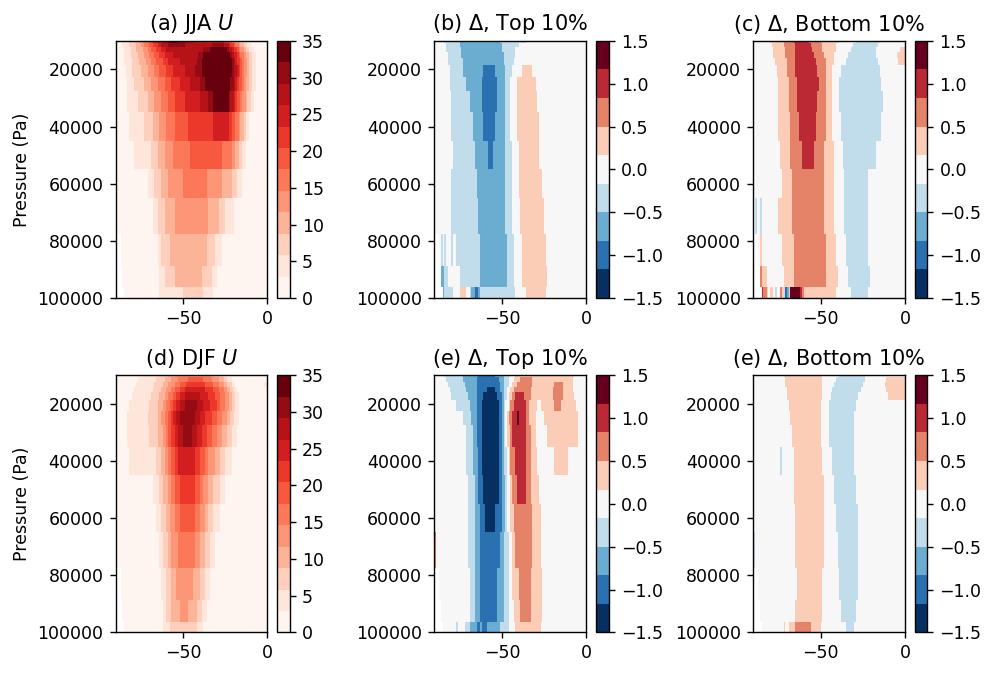

In [35]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
)
axs = axs.flatten()

mean_jja.plot(
    ax=axs[0],
    x="lat",
    vmax=35,
    vmin=0,
    extend="neither",
    cmap=plt.get_cmap("Reds", 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) JJA $U$")

(ds_v[var][midx_hi_jja, :, :, :].mean(dim=["time", "lon"]) - mean_jja).plot(
    ax=axs[1],
    x="lat",
    vmin=-1.5,
    vmax=1.5,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(ds_v[var][midx_lo_jja, :, :, :].mean(dim=["time", "lon"]) - mean_jja).plot(
    ax=axs[2],
    x="lat",
    vmin=-1.5,
    vmax=1.5,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[2].set_title("(c) $\Delta$, Bottom 10%")

mean_djf.plot(
    ax=axs[3],
    x="lat",
    vmax=35,
    vmin=0,
    extend="neither",
    cmap=plt.get_cmap("Reds", 12),
    cbar_kwargs={"label": ""},
)

axs[3].set_title("(d) DJF $U$")

(ds_v[var][midx_hi_djf, :, :, :].mean(dim=["time", "lon"]) - mean_djf).plot(
    ax=axs[4],
    x="lat",
    vmin=-1.5,
    vmax=1.5,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) $\Delta$, Top 10%")

(ds_v[var][midx_lo_djf, :, :, :].mean(dim=["time", "lon"]) - mean_djf).plot(
    ax=axs[5],
    x="lat",
    vmin=-1.5,
    vmax=1.5,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[5].set_title("(e) $\Delta$, Bottom 10%")

for i in range(6):
    axs[i].set_xlim([-90, 0])
    axs[i].set_ylim([100000, 10000])

    if (i == 0) | (i == 3):
        axs[i].set_ylabel("Pressure (Pa)")
    else:
        axs[i].set_ylabel("")
    axs[i].set_xlabel("")

plt.tight_layout()

## 2. Ocean conditions

In [3]:
var = "omldamax"

if var == "hf_turb":
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/ocean_monthly_1x1deg*hf*.nc",
        use_cftime=True,
    )
    ds_v = ds_v.assign(hf_turb=ds_v["hflso"] + ds_v["hfsso"])
else:
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/ocean_monthly_1x1deg*{var}.nc",
        use_cftime=True,
    )

In [8]:
midx_djf = ds_v.time.dt.month.isin([1, 2, 12])
midx_jja = ds_v.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(hi_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(lo_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))

midx_hi_jja = ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)

mean_djf = ds_v[var][midx_djf, :, :].mean(dim="time").compute()
#std_djf = ds_v[var][midx_djf, :, :].std(dim="time").compute()

mean_jja = ds_v[var][midx_jja, :, :].mean(dim="time").compute()
#std_jja = ds_v[var][midx_jja, :, :].std(dim="time").compute()

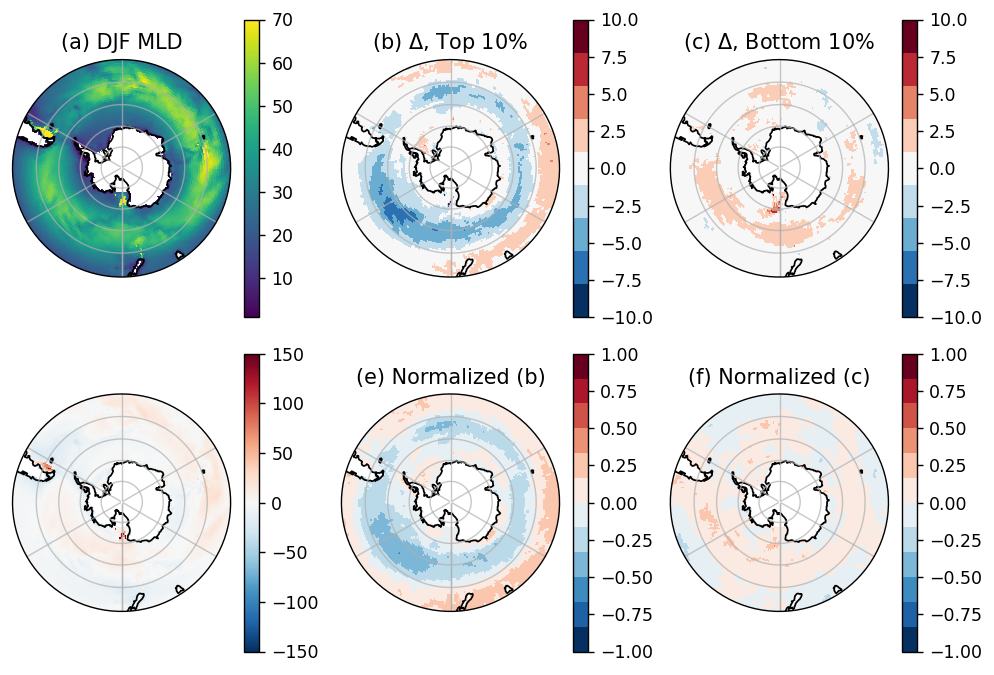

In [35]:
## Summer month composites

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


mean_djf.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=70,
    extend="neither",
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) DJF MLD")

## now including variations from zonal means

(mean_djf - mean_djf.mean(dim="lon")).plot(
    ax=axs[3],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmax=150,
    extend="neither",
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
# axs[3].set_title('(d) DJF SST minus zonal average')


(ds_v[var][midx_hi_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(ds_v[var][midx_lo_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$, Bottom 10%")


((ds_v[var][midx_hi_djf, :, :].mean(dim="time") - mean_djf) / std_djf).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) Normalized (b)")

((ds_v[var][midx_lo_djf, :, :].mean(dim="time") - mean_djf) / std_djf).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(f) Normalized (c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

# axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

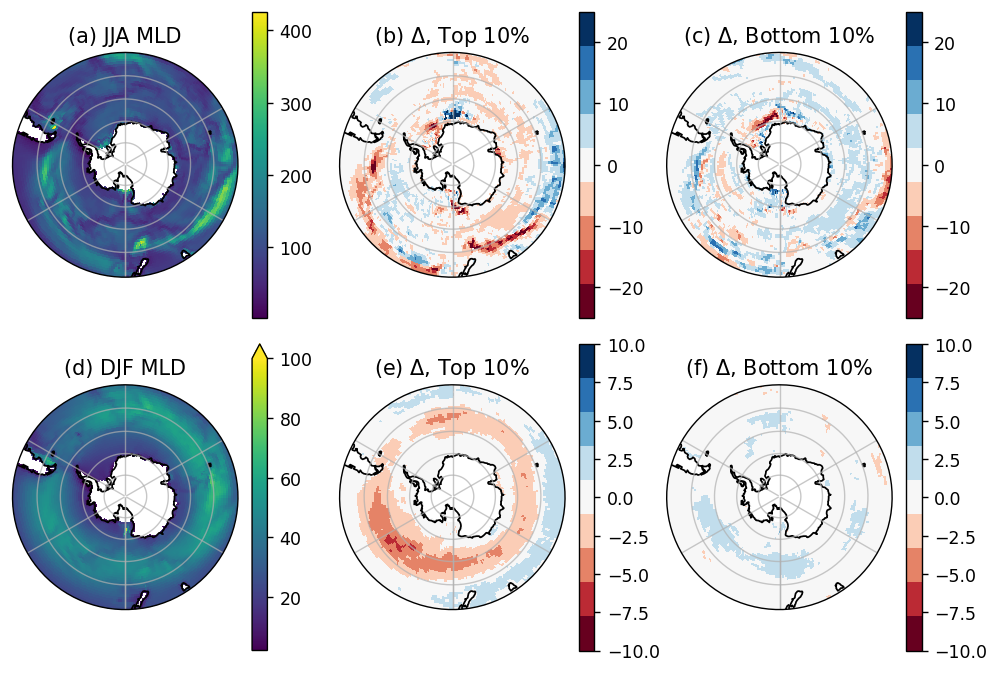

In [10]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

mean_jja.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    #vmin=100,
    #vmax=150,
    #extend="neither",
    #cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[0].set_title("(a) JJA MLD")

(ds_v[var][midx_hi_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-25,
    vmax=25,
    extend="neither",
    cmap=plt.get_cmap("RdBu", 9),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(ds_v[var][midx_lo_jja, :, :].mean(dim="time") - mean_jja).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-25,
    vmax=25,
    extend="neither",
    cmap=plt.get_cmap("RdBu", 9),
    cbar_kwargs={"label": ""},
)
axs[2].set_title("(c) $\Delta$, Bottom 10%")

mean_djf.plot(
    ax=axs[3],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    #vmin=-150,
    vmax=100,
    #extend="neither",
    #cmap=plt.get_cmap("RdBu_r", 9),
    cbar_kwargs={"label": ""},
)
axs[3].set_title("(d) DJF MLD")

(ds_v[var][midx_hi_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu", 9),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(e) $\Delta$, Top 10%")

(ds_v[var][midx_lo_djf, :, :].mean(dim="time") - mean_djf).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-10,
    vmax=10,
    extend="neither",
    cmap=plt.get_cmap("RdBu", 9),
    cbar_kwargs={"label": ""},
)
axs[5].set_title("(f) $\Delta$, Bottom 10%")

for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

plt.tight_layout()

## 2a. Ocean conditions _with depth_

In [11]:
var = "dissic"
ds_v = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/*{var}.nc",
    use_cftime=True,
)

midx_djf = ds_v.time.dt.month.isin([1, 2, 12])
midx_jja = ds_v.time.dt.month.isin([6, 7, 8])

mean_djf = ds_v[var][midx_djf, :, :, :].mean(dim="time").compute()
std_djf = ds_v[var][midx_djf, :, :, :].std(dim="time").compute()

mean_jja = ds_v[var][midx_jja, :, :, :].mean(dim="time").compute()
std_jja = ds_v[var][midx_jja, :, :, :].std(dim="time").compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [14]:
midx_hi_djf = (
    ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(hi_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(lo_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))

midx_hi_jja = ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)

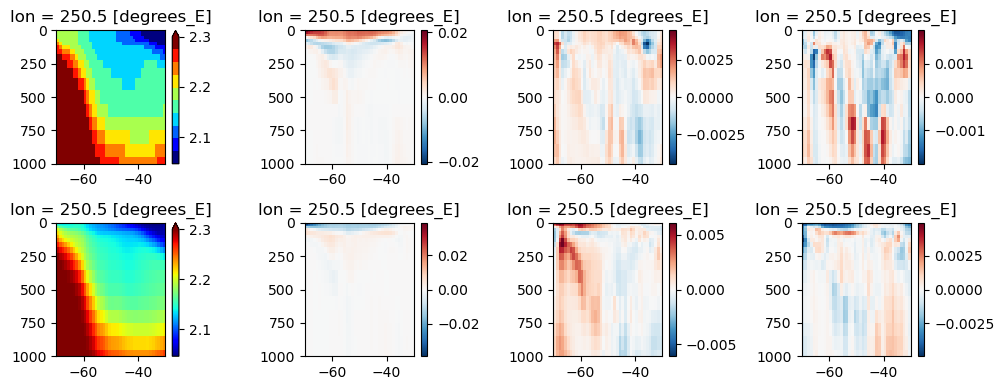

In [15]:
## Pacific transects

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
axs = axs.flatten()

mean_jja.sel(lat=slice(-70, -30)).sel(lon=250, method="nearest").plot(
    ax=axs[0], cbar_kwargs={"label": ""}, cmap=plt.get_cmap("jet",10), vmax=2.3
)

(mean_jja - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=250, method="nearest"
).plot(ax=axs[1], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=250, method="nearest").plot(ax=axs[2], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=250, method="nearest").plot(ax=axs[3], cbar_kwargs={"label": ""})

mean_djf.sel(lat=slice(-70, -30)).sel(lon=250, method="nearest").plot(
    ax=axs[4], cbar_kwargs={"label": ""}, cmap="jet", vmax=2.3
)

(mean_djf - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=250, method="nearest"
).plot(ax=axs[5], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=250, method="nearest").plot(ax=axs[6], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=250, method="nearest").plot(ax=axs[7], cbar_kwargs={"label": ""})

for i in range(8):
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_ylim([1000, 0])

plt.tight_layout()

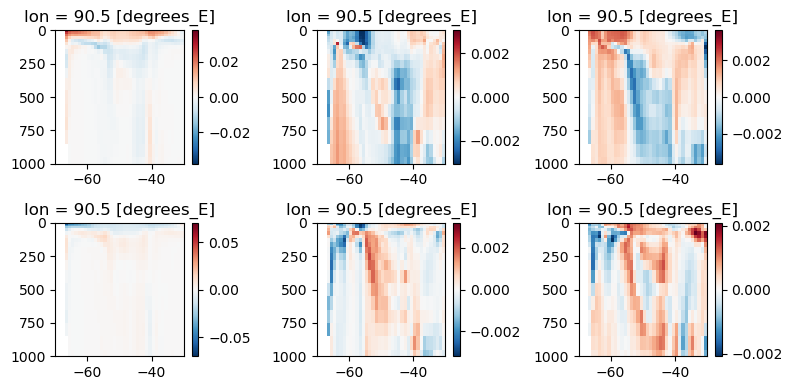

In [9]:
## Indian transects - just downstream of Kerguelen, around 90 deg E

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
axs = axs.flatten()

(mean_jja - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=90, method="nearest"
).plot(ax=axs[0], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=90, method="nearest").plot(ax=axs[1], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=90, method="nearest").plot(ax=axs[2], cbar_kwargs={"label": ""})

(mean_djf - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=90, method="nearest"
).plot(ax=axs[3], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=90, method="nearest").plot(ax=axs[4], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=90, method="nearest").plot(ax=axs[5], cbar_kwargs={"label": ""})

for i in range(6):
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_ylim([1000, 0])

plt.tight_layout()

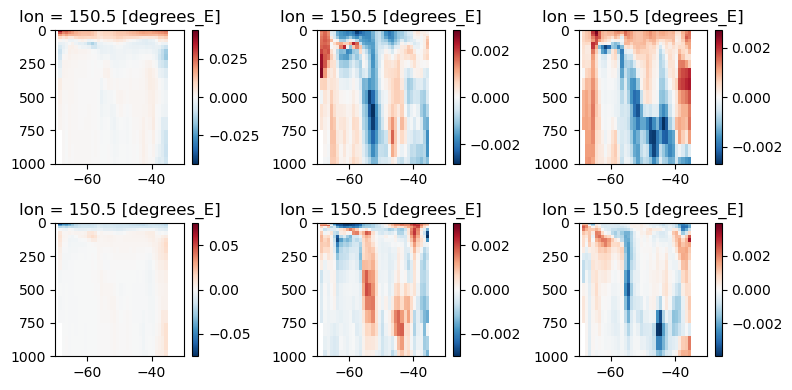

In [10]:
## Indian transects - further downstream of Kerguelen, around 150 deg E

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
axs = axs.flatten()

(mean_jja - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=150, method="nearest"
).plot(ax=axs[0], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=150, method="nearest").plot(ax=axs[1], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_jja, :, :, :].mean(dim="time") - mean_jja).sel(
    lat=slice(-70, -30)
).sel(lon=150, method="nearest").plot(ax=axs[2], cbar_kwargs={"label": ""})

(mean_djf - ds_v[var].mean(dim="time")).sel(lat=slice(-70, -30)).sel(
    lon=150, method="nearest"
).plot(ax=axs[3], cbar_kwargs={"label": ""})

(ds_v[var][midx_hi_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=150, method="nearest").plot(ax=axs[4], cbar_kwargs={"label": ""})

(ds_v[var][midx_lo_djf, :, :, :].mean(dim="time") - mean_djf).sel(
    lat=slice(-70, -30)
).sel(lon=150, method="nearest").plot(ax=axs[5], cbar_kwargs={"label": ""})

for i in range(6):
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_ylim([1000, 0])

plt.tight_layout()

## 3. Sea Ice conditions

In [20]:
ds_v = xr.open_mfdataset(
    "/work/Katherine.Turner/tempest-extremes/CM4_cmip/data/*siconc.nc", use_cftime=True
)

midx_djf = ds_v.time.dt.month.isin([1, 2, 12])
midx_jja = ds_v.time.dt.month.isin([6, 7, 8])

midx_hi_djf = (
    ds_v.time.dt.year.isin(hi_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(hi_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))
midx_lo_djf = (
    ds_v.time.dt.year.isin(lo_djf.dt.year) & ds_v.time.dt.month.isin([12])
) | (ds_v.time.dt.year.isin(lo_djf.dt.year + 1) & ds_v.time.dt.month.isin([1, 2]))

midx_hi_jja = ds_v.time.dt.year.isin(hi_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)
midx_lo_jja = ds_v.time.dt.year.isin(lo_jja.dt.year) & ds_v.time.dt.month.isin(
    [6, 7, 8]
)

siconc_djf = ds_v.siconc[midx_djf, :, :].mean(dim="time").compute()
siconc_djf_std = ds_v.siconc[midx_djf, :, :].std(dim="time").compute()

siconc_jja = ds_v.siconc[midx_jja, :, :].mean(dim="time").compute()
siconc_jja_std = ds_v.siconc[midx_jja, :, :].std(dim="time").compute()

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


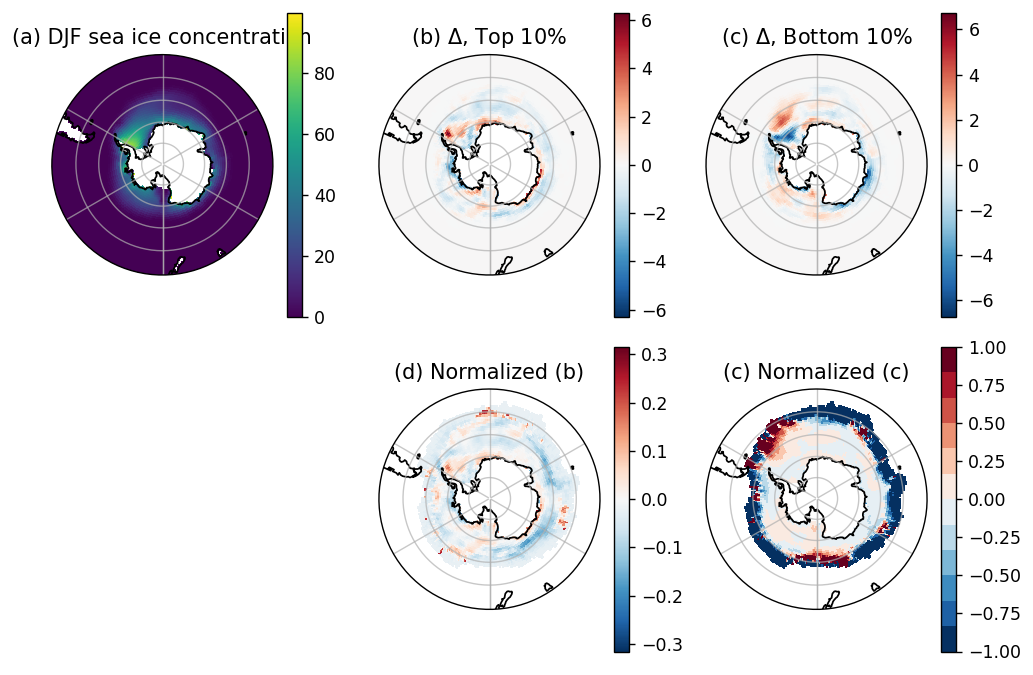

In [19]:
## Summer month composites

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


siconc_djf.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) DJF sea ice concentration")

### now including variations from zonal means
#
# (ds_v.siconc_djf[midx_djf,:,:].mean(dim='time') - ds_v.siconc_djf[midx_djf,:,:].mean(dim='time').mean(dim='lon')).plot(ax=axs[3],
#                                                                                                               x='lon', y='lat',
#                                                                                                               transform=ccrs.PlateCarree(),
#                                                                                                               #vmax=18, extend='neither',
#                                                                                                               #cmap=plt.get_cmap('viridis', 12),
#                                                                                                               cbar_kwargs={'label':''},
#                                                                                                              )


(ds_v.siconc[midx_hi_djf, :, :].mean(dim="time") - siconc_djf).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(ds_v.siconc[midx_lo_djf, :, :].mean(dim="time") - siconc_djf).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$, Bottom 10%")


((ds_v.siconc[midx_hi_djf, :, :].mean(dim="time") - siconc_djf) / siconc_djf_std).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(d) Normalized (b)")

((ds_v.siconc[midx_lo_djf, :, :].mean(dim="time") - siconc_djf) / siconc_djf_std).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(c) Normalized (c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)

AttributeError: 'Dataset' object has no attribute 'siconc'

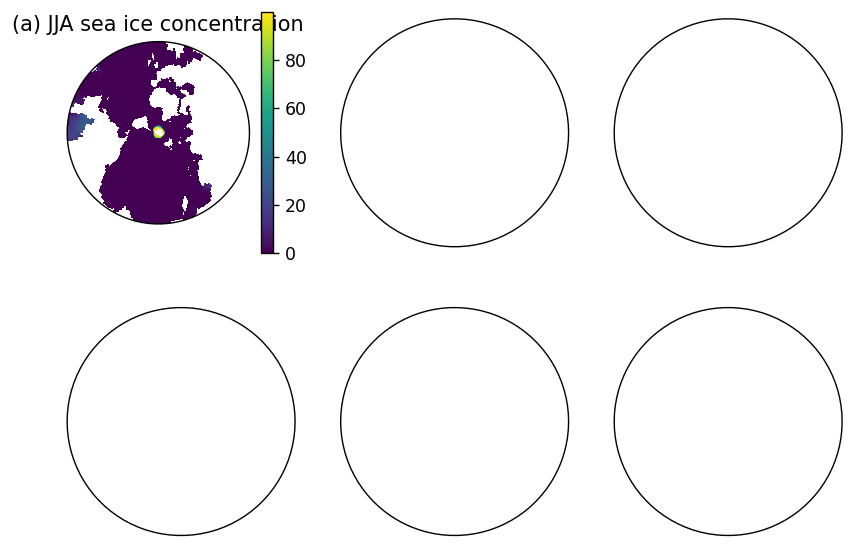

In [25]:
## Winter month composites

fig, axs = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5.5),
    dpi=125,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()


siconc_jja.plot(
    ax=axs[0],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[0].set_title("(a) JJA sea ice concentration")

### now including variations from zonal means
#
# (ds_v.siconc[midx_djf,:,:].mean(dim='time') - ds_v.siconc[midx_djf,:,:].mean(dim='time').mean(dim='lon')).plot(ax=axs[3],
#                                                                                                               x='lon', y='lat',
#                                                                                                               transform=ccrs.PlateCarree(),
#                                                                                                               #vmax=18, extend='neither',
#                                                                                                               #cmap=plt.get_cmap('viridis', 12),
#                                                                                                               cbar_kwargs={'label':''},
#                                                                                                              )


(ds_v.siconc[midx_hi_jja, :, :].mean(dim="time") - siconc_jja).plot(
    ax=axs[1],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[1].set_title("(b) $\Delta$, Top 10%")

(ds_v.siconc[midx_lo_jja, :, :].mean(dim="time") - siconc_jja).plot(
    ax=axs[2],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)

axs[2].set_title("(c) $\Delta$, Bottom 10%")


((ds_v.siconc[midx_hi_jja, :, :].mean(dim="time") - siconc_jja) / siconc_jja_std).plot(
    ax=axs[4],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    # vmax=18, extend='neither',
    # cmap=plt.get_cmap('viridis', 12),
    cbar_kwargs={"label": ""},
)
axs[4].set_title("(d) Normalized (b)")

((ds_v.siconc[midx_lo_jja, :, :].mean(dim="time") - siconc_jja) / siconc_jja_std).plot(
    ax=axs[5],
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 12),
    cbar_kwargs={"label": ""},
)

axs[5].set_title("(c) Normalized (c)")


for i in range(6):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

axs[3].remove()
plt.tight_layout()

# #plt.savefig(f"{out_path_fig}storm_activity_djf_CM4-500.png", format='png', dpi=100)